Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
sensitive_attribute = "gender"

## Load Dataset

In [3]:
DATAFILE= "bar_pass_prediction.csv"

#learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster','zgpa','fulltime','fam_inc','Dropout','tier','gpa','pass_bar'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1.33,female,white
1,29.0,3.5,-0.11,female,white
2,36.0,3.5,-0.64,male,white
3,39.0,3.5,0.34,male,white
4,48.0,3.5,1.02,male,white


In [4]:
df.zfygpa = np.where(df.zfygpa >= df.zfygpa.median(),1,0)

In [5]:
df.head()

,lsat,ugpa,zfygpa,gender,race1
0,44.0,3.5,1,female,white
1,29.0,3.5,0,female,white
2,36.0,3.5,0,male,white
3,39.0,3.5,1,male,white
4,48.0,3.5,1,male,white


## Model training and test

In [6]:
X = df.drop('zfygpa', axis=1)
y = df['zfygpa']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

Wall time: 584 ms


array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.])

In [8]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.63      0.52      0.57      3206
           1       0.59      0.69      0.64      3216

    accuracy                           0.61      6422
   macro avg       0.61      0.61      0.60      6422
weighted avg       0.61      0.61      0.60      6422



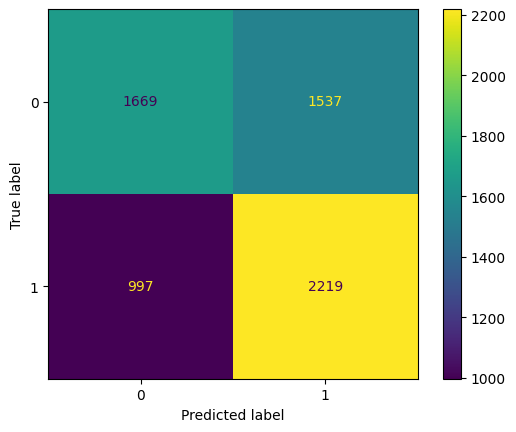

In [9]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [10]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [11]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00, 16.82it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:00<00:00, 668.73it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 76/76 [00:00<00:00, 2454.74it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 876/876 [00:09<00:00, 91.03it/s] 

Number of if-thens: 876


In [12]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [13]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [12]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["male"][1][0][1]-e[1]["female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If lsat = 27.0:
	Subgroup 'female', 2.26% covered
		Make lsat = 40.0 with correctness 32.26%.
		Make lsat = 39.0 with correctness 29.03%.
		Make lsat = 38.0 with correctness 29.03%.
		Make lsat = 37.0 with correctness 25.81%.
		Make lsat = 41.0 with correctness 35.48%.
		Make lsat = 42.0 with correctness 35.48%.
		Make lsat = 36.0 with correctness 25.81%.
		Make lsat = 44.0 with correctness 35.48%.
		Make lsat = 43.0 with correctness 35.48%.
		Make lsat = 35.0 with correctness 16.13%.
		Make lsat = 45.0 with correctness 35.48%.
		Make lsat = 34.0 with correctness 12.90%.
		Make lsat = 46.0 with correctness 35.48%.
		Make lsat = 48.0 with correctness 35.48%.
		Make lsat = 47.0 with correctness 35.48%.
		Make lsat = 33.0 with correctness 12.90%.
	Subgroup 'male', 2.16% covered
		Make lsat = 40.0 with correctness 64.29%.
		Make lsat = 39.0 with correctness 64.29%.
		Make lsat = 38.0 with correctness 60.71%.
		Make lsat = 37.0 with correctness 42.86%.
		Make lsat = 41.0 with correctness 67

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [13]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [14]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 2.5, race1 = black:
	Subgroup 'female', 1.46% covered out of 9331
		Make ugpa = 3.4, race1 = white with correctness 20.00%.
		Make ugpa = 3.6, race1 = white with correctness 20.00%.
		Make ugpa = 3.7, race1 = white with correctness 25.00%.
		Make ugpa = 3.3, race1 = white with correctness 10.00%.
		Make ugpa = 3.2, race1 = white with correctness 10.00%.
		Make ugpa = 3.8, race1 = white with correctness 30.00%.
		Make ugpa = 3.0, race1 = white with correctness 10.00%.
		Make ugpa = 3.9, race1 = white with correctness 30.00%.
		Make ugpa = 2.9, race1 = white with correctness 10.00%.
		Make ugpa = 2.8, race1 = white with correctness 5.00%.
		Make ugpa = 2.6, race1 = white with correctness 0.00%.
		Aggregate cost of the above recourses = -0.3
	Subgroup 'male', 1.16% covered out of 12075
		Make ugpa = 3.4, race1 = white with correctness 46.67%.
		Make ugpa = 3.6, race1 = white with correctness 53.33%.
		Make ugpa = 3.7, race1 = white with correctness 60.00%.
		Make ugpa = 3.3, rac

## Minimum cost above threshold

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 3.3:
	Subgroup 'female', 8.98% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.32% covered out of 12075
		Make ugpa = 3.8 with correctness 53.66%.
		Make ugpa = 3.9 with correctness 58.54%.
		Aggregate cost of the above recourses = 1e+00
	Bias against female. Unfairness measure = inf.
If race1 = white, ugpa = 3.1:
	Subgroup 'female', 7.74% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.09% covered out of 12075
		Make ugpa = 3.5 with correctness 56.96%.
		Aggregate cost of the above recourses = 1e+00
	Bias against female. Unfairness measure = inf.
If ugpa = 2.8:
	Subgroup 'female', 7.09% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 8.02% covered out of 12075
		Make ugpa = 3.5 with correctness 52.88%.
		Make ugpa = 3.6 with correctness 57.69%.
		Make ugpa = 3.7 wi

## Mean cost above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If ugpa = 3.3:
	Subgroup 'female', 8.98% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.32% covered out of 12075
		Make ugpa = 3.8 with correctness 53.66%.
		Make ugpa = 3.9 with correctness 58.54%.
		Aggregate cost of the above recourses = 1e+00
	Bias against female. Unfairness measure = inf.
If race1 = white, ugpa = 3.1:
	Subgroup 'female', 7.74% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.09% covered out of 12075
		Make ugpa = 3.5 with correctness 56.96%.
		Aggregate cost of the above recourses = 1e+00
	Bias against female. Unfairness measure = inf.
If ugpa = 2.8:
	Subgroup 'female', 7.09% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 8.02% covered out of 12075
		Make ugpa = 3.5 with correctness 52.88%.
		Make ugpa = 3.6 with correctness 57.69%.
		Make ugpa = 3.7 wi

## Number above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If lsat = 28.0:
	Subgroup 'female', 2.99% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0e+00
	Subgroup 'male', 4.01% covered out of 12075
		Make lsat = 40.0 with correctness 61.54%.
		Make lsat = 39.0 with correctness 59.62%.
		Make lsat = 38.0 with correctness 57.69%.
		Make lsat = 37.0 with correctness 50.00%.
		Make lsat = 41.0 with correctness 61.54%.
		Make lsat = 42.0 with correctness 61.54%.
		Make lsat = 44.0 with correctness 63.46%.
		Make lsat = 43.0 with correctness 61.54%.
		Make lsat = 45.0 with correctness 63.46%.
		Make lsat = 46.0 with correctness 65.38%.
		Make lsat = 48.0 with correctness 69.23%.
		Make lsat = 47.0 with correctness 67.31%.
		Aggregate cost of the above recourses = -1e+01
	Bias against female. Unfairness measure = 12.
If lsat = 27.0:
	Subgroup 'female', 2.26% covered out of 9331
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0e+00
	Subgroup 'male', 2.16% covered out of 1207

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [20]:
import dill

with open("stateLawSchool.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

Trying to unpickle estimator LogisticRegression from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


If ugpa = 2.5, race1 = black:
	Subgroup 'female', 1.46% covered out of 9331
		Make ugpa = 3.4, race1 = white with correctness 20.00%.
		Make ugpa = 3.6, race1 = white with correctness 20.00%.
		Make ugpa = 3.7, race1 = white with correctness 25.00%.
		Make ugpa = 3.3, race1 = white with correctness 10.00%.
		Make ugpa = 3.2, race1 = white with correctness 10.00%.
		Make ugpa = 3.8, race1 = white with correctness 30.00%.
		Make ugpa = 3.0, race1 = white with correctness 10.00%.
		Make ugpa = 3.9, race1 = white with correctness 30.00%.
		Make ugpa = 2.9, race1 = white with correctness 10.00%.
		Make ugpa = 2.8, race1 = white with correctness 5.00%.
		Make ugpa = 2.6, race1 = white with correctness 0.00%.
	Subgroup 'male', 1.16% covered out of 12075
		Make ugpa = 3.4, race1 = white with correctness 46.67%.
		Make ugpa = 3.6, race1 = white with correctness 53.33%.
		Make ugpa = 3.7, race1 = white with correctness 60.00%.
		Make ugpa = 3.3, race1 = white with correctness 40.00%.
		Make ugpa

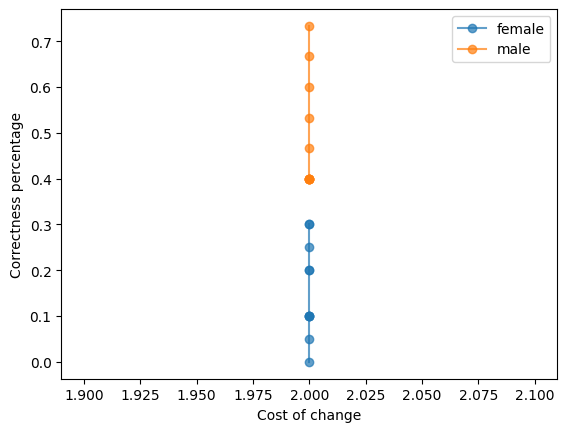

If lsat = 35.0, ugpa = 2.9:
	Subgroup 'female', 1.10% covered out of 9331
		Make lsat = 40.0, ugpa = 3.2 with correctness 73.33%.
		Make lsat = 38.0, ugpa = 3.2 with correctness 73.33%.
		Make lsat = 39.0, ugpa = 3.3 with correctness 73.33%.
		Make lsat = 37.0, ugpa = 3.1 with correctness 73.33%.
		Make lsat = 39.0, ugpa = 3.2 with correctness 73.33%.
		Make lsat = 37.0, ugpa = 3.3 with correctness 73.33%.
		Make lsat = 36.0, ugpa = 3.3 with correctness 73.33%.
	Subgroup 'male', 1.46% covered out of 12075
		Make lsat = 40.0, ugpa = 3.2 with correctness 100.00%.
		Make lsat = 38.0, ugpa = 3.2 with correctness 100.00%.
		Make lsat = 39.0, ugpa = 3.3 with correctness 100.00%.
		Make lsat = 37.0, ugpa = 3.1 with correctness 100.00%.
		Make lsat = 39.0, ugpa = 3.2 with correctness 100.00%.
		Make lsat = 37.0, ugpa = 3.3 with correctness 100.00%.
		Make lsat = 36.0, ugpa = 3.3 with correctness 100.00%.
	Bias against female. Unfairness measure = 0.53.
	Cumulative correctness plot for the abov

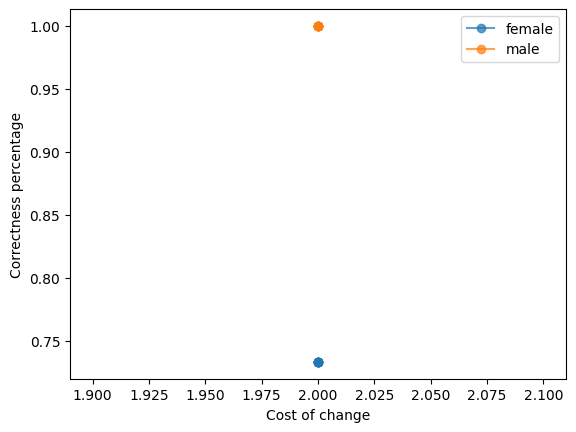

If lsat = 34.0, ugpa = 3.1:
	Subgroup 'female', 1.39% covered out of 9331
		Make lsat = 40.0, ugpa = 3.2 with correctness 68.42%.
		Make lsat = 38.0, ugpa = 3.2 with correctness 68.42%.
		Make lsat = 39.0, ugpa = 3.3 with correctness 68.42%.
		Make lsat = 37.0 with correctness 68.42%.
		Make lsat = 39.0, ugpa = 3.2 with correctness 68.42%.
		Make lsat = 37.0, ugpa = 3.3 with correctness 68.42%.
		Make lsat = 36.0, ugpa = 3.3 with correctness 68.42%.
	Subgroup 'male', 1.46% covered out of 12075
		Make lsat = 40.0, ugpa = 3.2 with correctness 94.74%.
		Make lsat = 38.0, ugpa = 3.2 with correctness 94.74%.
		Make lsat = 39.0, ugpa = 3.3 with correctness 94.74%.
		Make lsat = 37.0 with correctness 94.74%.
		Make lsat = 39.0, ugpa = 3.2 with correctness 94.74%.
		Make lsat = 37.0, ugpa = 3.3 with correctness 94.74%.
		Make lsat = 36.0, ugpa = 3.3 with correctness 94.74%.
	Bias against female. Unfairness measure = 0.49.
	Cumulative correctness plot for the above recourses:


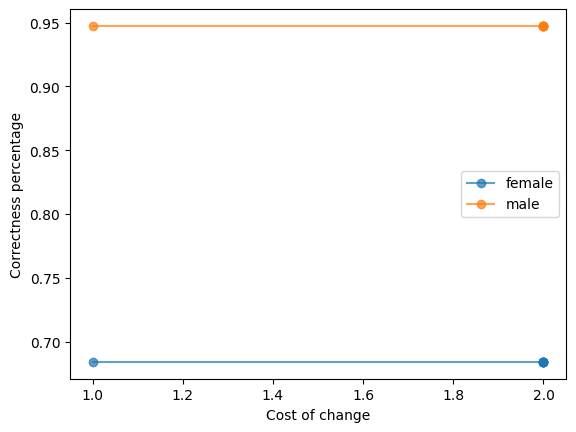

If lsat = 27.0:
	Subgroup 'female', 2.26% covered out of 9331
		Make lsat = 40.0 with correctness 32.26%.
		Make lsat = 39.0 with correctness 29.03%.
		Make lsat = 38.0 with correctness 29.03%.
		Make lsat = 37.0 with correctness 25.81%.
		Make lsat = 41.0 with correctness 35.48%.
		Make lsat = 42.0 with correctness 35.48%.
		Make lsat = 36.0 with correctness 25.81%.
		Make lsat = 44.0 with correctness 35.48%.
		Make lsat = 43.0 with correctness 35.48%.
		Make lsat = 35.0 with correctness 16.13%.
		Make lsat = 45.0 with correctness 35.48%.
		Make lsat = 34.0 with correctness 12.90%.
		Make lsat = 46.0 with correctness 35.48%.
		Make lsat = 48.0 with correctness 35.48%.
		Make lsat = 47.0 with correctness 35.48%.
		Make lsat = 33.0 with correctness 12.90%.
	Subgroup 'male', 2.16% covered out of 12075
		Make lsat = 40.0 with correctness 64.29%.
		Make lsat = 39.0 with correctness 64.29%.
		Make lsat = 38.0 with correctness 60.71%.
		Make lsat = 37.0 with correctness 42.86%.
		Make lsat =

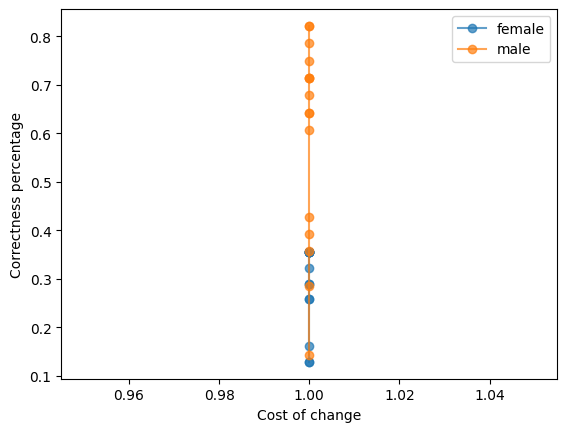

If lsat = 24.0:
	Subgroup 'female', 1.10% covered out of 9331
		Make lsat = 40.0 with correctness 20.00%.
		Make lsat = 39.0 with correctness 20.00%.
		Make lsat = 38.0 with correctness 20.00%.
		Make lsat = 37.0 with correctness 13.33%.
		Make lsat = 41.0 with correctness 20.00%.
		Make lsat = 42.0 with correctness 20.00%.
		Make lsat = 36.0 with correctness 13.33%.
		Make lsat = 44.0 with correctness 20.00%.
		Make lsat = 43.0 with correctness 20.00%.
		Make lsat = 35.0 with correctness 6.67%.
		Make lsat = 45.0 with correctness 20.00%.
		Make lsat = 34.0 with correctness 6.67%.
		Make lsat = 46.0 with correctness 20.00%.
		Make lsat = 48.0 with correctness 26.67%.
		Make lsat = 47.0 with correctness 20.00%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'male', 1.08% covered out of 12075
		Make lsat = 40.0 with correctness 50.00%.
		Make lsat = 39.0 with correctness 50.00%.
		Make lsat = 38.0 with correctness 50.00%.
		Make lsat = 37.0 with correctness 28.57%.
		Make lsat = 41

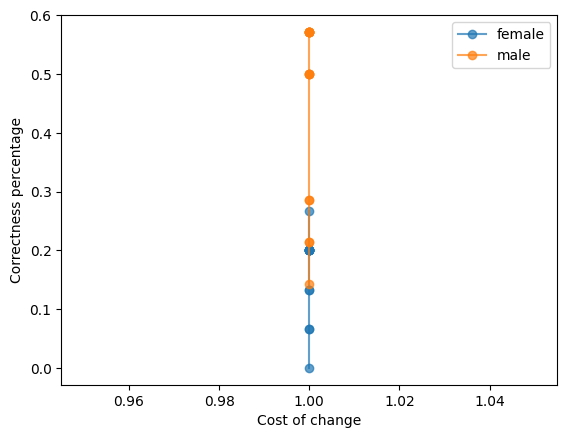

If lsat = 28.0:
	Subgroup 'female', 2.99% covered out of 9331
		Make lsat = 40.0 with correctness 36.59%.
		Make lsat = 39.0 with correctness 36.59%.
		Make lsat = 38.0 with correctness 36.59%.
		Make lsat = 37.0 with correctness 36.59%.
		Make lsat = 41.0 with correctness 36.59%.
		Make lsat = 42.0 with correctness 39.02%.
		Make lsat = 36.0 with correctness 34.15%.
		Make lsat = 44.0 with correctness 39.02%.
		Make lsat = 43.0 with correctness 39.02%.
		Make lsat = 35.0 with correctness 26.83%.
		Make lsat = 45.0 with correctness 39.02%.
		Make lsat = 34.0 with correctness 26.83%.
		Make lsat = 46.0 with correctness 39.02%.
		Make lsat = 48.0 with correctness 39.02%.
		Make lsat = 47.0 with correctness 39.02%.
		Make lsat = 33.0 with correctness 7.32%.
	Subgroup 'male', 4.01% covered out of 12075
		Make lsat = 40.0 with correctness 61.54%.
		Make lsat = 39.0 with correctness 59.62%.
		Make lsat = 38.0 with correctness 57.69%.
		Make lsat = 37.0 with correctness 50.00%.
		Make lsat = 

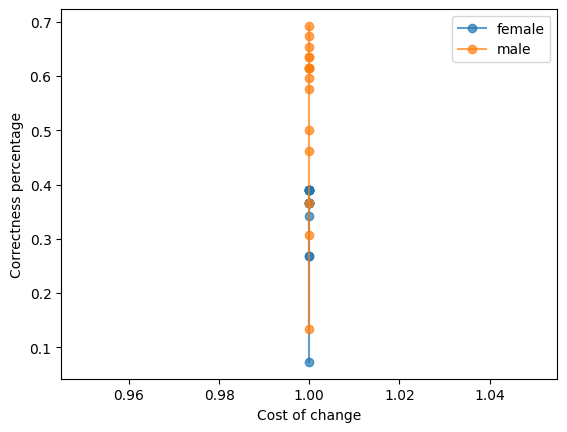

If race1 = other:
	Subgroup 'female', 3.80% covered out of 9331
		Make race1 = white with correctness 36.54%.
	Subgroup 'male', 5.01% covered out of 12075
		Make race1 = white with correctness 53.85%.
	Bias against female. Unfairness measure = 0.17.
	Cumulative correctness plot for the above recourses:


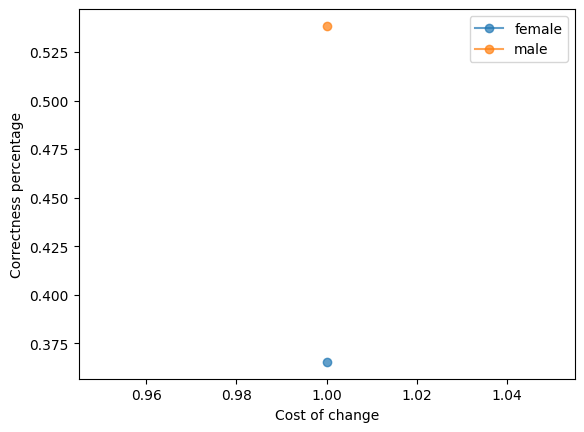

If lsat = 25.0:
	Subgroup 'female', 1.53% covered out of 9331
		Make lsat = 40.0 with correctness 23.81%.
		Make lsat = 39.0 with correctness 23.81%.
		Make lsat = 38.0 with correctness 19.05%.
		Make lsat = 37.0 with correctness 14.29%.
		Make lsat = 41.0 with correctness 28.57%.
		Make lsat = 42.0 with correctness 28.57%.
		Make lsat = 36.0 with correctness 9.52%.
		Make lsat = 44.0 with correctness 28.57%.
		Make lsat = 43.0 with correctness 28.57%.
		Make lsat = 35.0 with correctness 9.52%.
		Make lsat = 45.0 with correctness 28.57%.
		Make lsat = 34.0 with correctness 9.52%.
		Make lsat = 46.0 with correctness 28.57%.
		Make lsat = 48.0 with correctness 28.57%.
		Make lsat = 47.0 with correctness 28.57%.
		Make lsat = 33.0 with correctness 0.00%.
	Subgroup 'male', 1.46% covered out of 12075
		Make lsat = 40.0 with correctness 42.11%.
		Make lsat = 39.0 with correctness 42.11%.
		Make lsat = 38.0 with correctness 42.11%.
		Make lsat = 37.0 with correctness 36.84%.
		Make lsat = 41.

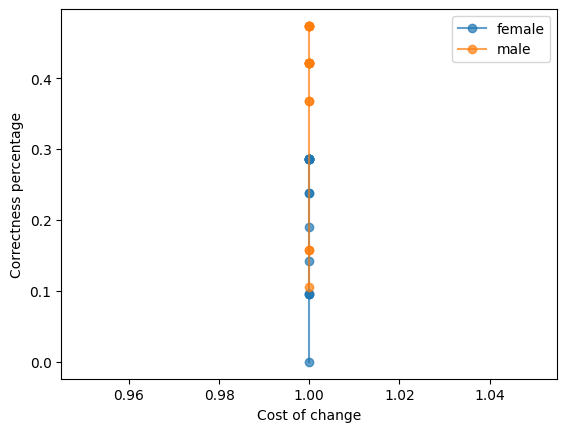

If ugpa = 2.7:
	Subgroup 'female', 5.33% covered out of 9331
		Make ugpa = 3.4 with correctness 32.88%.
		Make ugpa = 3.5 with correctness 36.99%.
		Make ugpa = 3.6 with correctness 36.99%.
		Make ugpa = 3.7 with correctness 41.10%.
		Make ugpa = 3.3 with correctness 26.03%.
		Make ugpa = 3.2 with correctness 26.03%.
		Make ugpa = 3.1 with correctness 16.44%.
		Make ugpa = 3.8 with correctness 43.84%.
		Make ugpa = 3.0 with correctness 9.59%.
		Make ugpa = 3.9 with correctness 43.84%.
		Make ugpa = 2.9 with correctness 8.22%.
		Make ugpa = 2.8 with correctness 8.22%.
		Make ugpa = 2.6 with correctness 0.00%.
	Subgroup 'male', 9.10% covered out of 12075
		Make ugpa = 3.4 with correctness 50.00%.
		Make ugpa = 3.5 with correctness 53.39%.
		Make ugpa = 3.6 with correctness 62.71%.
		Make ugpa = 3.7 with correctness 64.41%.
		Make ugpa = 3.3 with correctness 43.22%.
		Make ugpa = 3.2 with correctness 42.37%.
		Make ugpa = 3.1 with correctness 34.75%.
		Make ugpa = 3.8 with correctness 67.

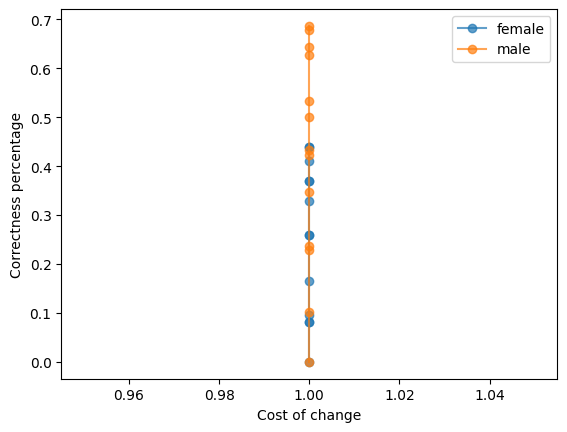

If lsat = 33.0, ugpa = 3.1:
	Subgroup 'female', 1.46% covered out of 9331
		Make lsat = 40.0, ugpa = 3.2 with correctness 90.00%.
		Make lsat = 38.0, ugpa = 3.2 with correctness 90.00%.
		Make lsat = 39.0, ugpa = 3.3 with correctness 90.00%.
		Make lsat = 37.0 with correctness 90.00%.
		Make lsat = 39.0, ugpa = 3.2 with correctness 90.00%.
		Make lsat = 37.0, ugpa = 3.3 with correctness 90.00%.
		Make lsat = 36.0, ugpa = 3.3 with correctness 90.00%.
	Subgroup 'male', 1.23% covered out of 12075
		Make lsat = 40.0, ugpa = 3.2 with correctness 81.25%.
		Make lsat = 38.0, ugpa = 3.2 with correctness 81.25%.
		Make lsat = 39.0, ugpa = 3.3 with correctness 81.25%.
		Make lsat = 37.0 with correctness 81.25%.
		Make lsat = 39.0, ugpa = 3.2 with correctness 81.25%.
		Make lsat = 37.0, ugpa = 3.3 with correctness 81.25%.
		Make lsat = 36.0, ugpa = 3.3 with correctness 81.25%.
	Bias against male. Unfairness measure = 0.16.
	Cumulative correctness plot for the above recourses:


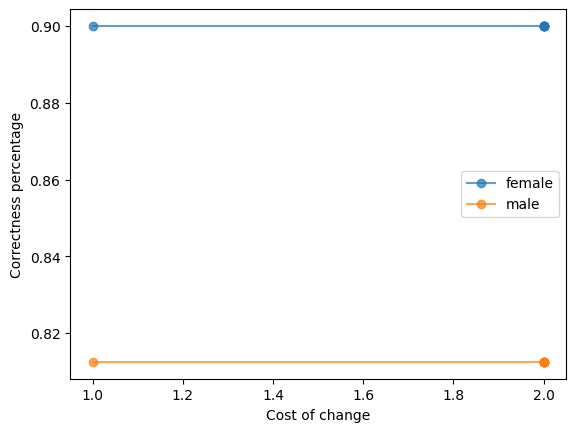

In [18]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (df[sensitive_attribute] == sg).sum() for sg in df[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [22]:
import dill

with open("stateLawSchool.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)